### QML 4a. Introduction to Quantum Kernels
Quantum kernels and their use in support vector machines is explained on a toy dataset.

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### 1. Single Kernel entry
Let us first learn to compute single entry of the kernel matrix. 

#### Step 1: Data Encoding

Let us first consider a data set with just a few features, say 10. We take just two points, containing 10 features and one label y=-1 or 1. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Two mock data points, including category labels, as in training
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]
 
# Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]

Let us use z feature map with 10 parameters for data encoding and as a feature map. After the map, we assign classical data to the paramters of the circuit

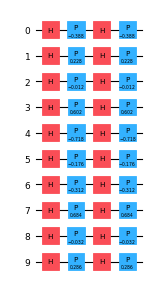

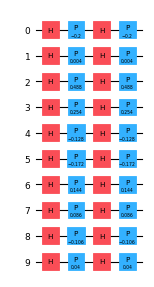

In [9]:
# from qiskit.circuit.library import zz_feature_map
# fm = zz_feature_map(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)
 
from qiskit.circuit.library import z_feature_map
 
fm = z_feature_map(feature_dimension=np.shape(train_data)[1])
 
 
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])
display(unitary1.draw('mpl',scale=0.4),unitary2.draw('mpl',scale=0.4))

Kernel matrix entry

For the task of generating a kernel matrix, we need kernel entry as the following inner product

$$
\langle\psi(\vec{x}_j)|\psi(\vec{x}_i)\rangle = \langle 0 |^{\otimes N}\Phi^\dagger(\vec{x}_j)\Phi(\vec{x}_i)|0\rangle^{\otimes N}
$$

This can be computed in many ways. One possibility is to use the inversion test, that we do in the below code using unitary_overlap that combine the first unitary with the dagger of the second unitary.



circuit depth after decomposing =  9


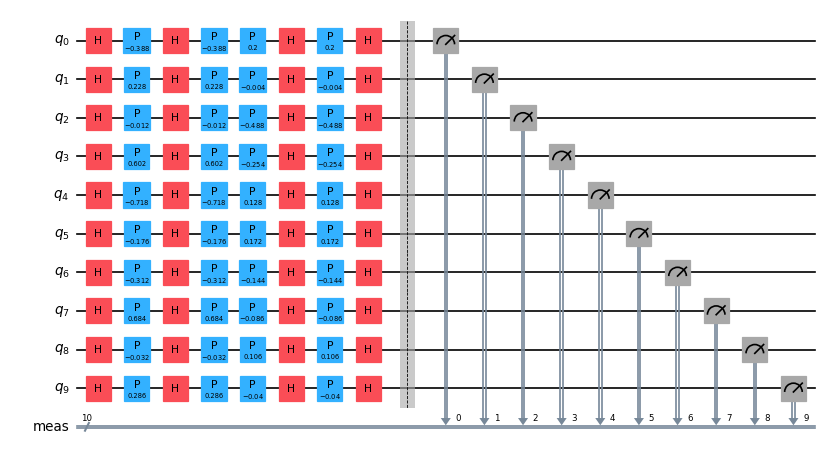

In [10]:
from qiskit.circuit.library import unitary_overlap
 
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
 
print("circuit depth after decomposing = ", overlap_circ.decompose().depth())
overlap_circ.draw("mpl", scale=0.6, style="iqp")

#### Step 2: Optimize problem for quantum execution
Make your account at [quantum.cloud.ibm.com](quantum.cloud.ibm.com) and make a new instant. Once you make the instant, copy the instant CRN and the API key (token) in the below cell. Name your account the way you want.

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService
token = "kzaCKJBDseQEMRe4GpcqkU3G4zG1ccXw_8hkE7aJecTL"
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud",
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/a9b97467e1764d528c81e4fb88381d3e:b88de043-31d6-486c-b693-7d9b016a8166::",
  overwrite=True
)

We start by selecting the least busy backend, then optimize our circuit for running on that backend.

In [12]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False
)
print(backend)

<IBMBackend('ibm_yonsei')>


In [13]:
# Apply level 3 optimization to our overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

In [14]:
print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)

circuit depth =  10


1

#### Step 3: Execute using Qiskit Runtime Primitives
We will run it on simulator for expeditious example. You can comment this code and uncomment the code in the following cell to run on IBM quantum computers

In [15]:
from qiskit.primitives import StatevectorSampler
 
from qiskit_ibm_runtime import Options, Session, Sampler
 
num_shots = 10000
 
#Evaluate the problem using state vector-based primitives from Qiskit
sampler = StatevectorSampler()
results = sampler.run([overlap_circ], shots=num_shots).result()
#.get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
#.get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

In [16]:
##Benchmarked on an Torino processor, 09-30-25, took 4 sec.
 
## Import our runtime primitive
#from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
#num_shots = 10000
 
## Use sampler and get the counts
 
#sampler = Sampler(mode=backend)
#results = sampler.run([overlap_ibm], shots=num_shots).result()
## .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
#counts_bit = results[0].data.meas.get_counts()
## .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
#counts = results[0].data.meas.get_int_counts()

#### Step 4: Post-process, return result in classical format

Kernel entry =  0.6911


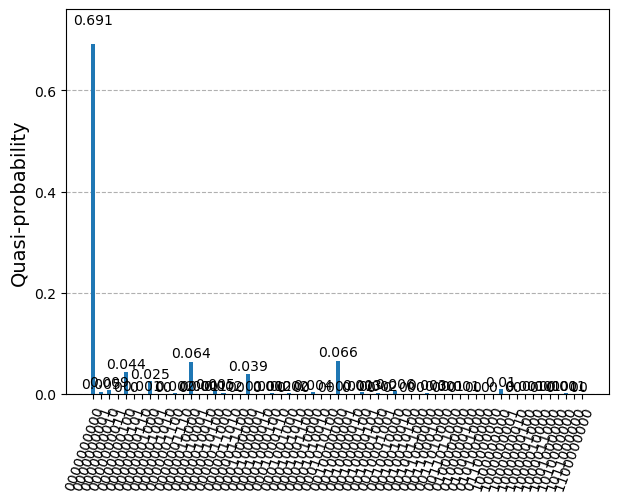

In [17]:

from qiskit.visualization import plot_distribution
counts.get(0, 0.0) / num_shots
print("Kernel entry = ", counts.get(0, 0.0) / num_shots)
plot_distribution(counts_bit)

### 2. Full kernel matrix

### Step 1: Map classical inputs to a quantum problem

Now we will import an existing dataset for our classification. This dataset consists of 128 rows (data points) and 14 features on each point. There is a 15th element that indicates the binary category of each point ($\pm 1$). The dataset is imported below, or you can access the dataset and view its structure [here](https://github.com/qiskit-community/prototype-quantum-kernel-training/blob/main/data/dataset_graph7.csv).

We will use the first 90 data points for training, and the next 30 points for testing.

In [20]:

df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
 
# Prepare training data
 
train_size = 90
X_train = df.values[0:train_size, :-1]
train_labels = df.values[0:train_size, -1]
 
# Prepare testing data
test_size = 30
X_test = df.values[train_size : train_size + test_size, :-1]
test_labels = df.values[train_size : train_size + test_size, -1]

In [21]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

Let us use a custom parameteric circuit as quantum feature map for the kernel matrix with 14 features.

Note the inclusion of an additioonal trainable parameter $\theta$ which we will keep fixed, but it can be trained.

circuit depth of one unitary in feature map=  11


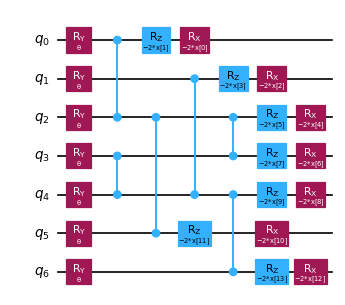

In [22]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
 
# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
 
# To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
 
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ") # This can be used to train the feature map
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)
print("circuit depth of one unitary in feature map= ", fm.decompose().depth())
fm.draw("mpl", scale=0.6)

### Step 2 on Simulator
We do not need to optimize for the simulator and we directly run the loop over the whole dataset to compute all kernel etnries 1. For training matrix, we compute inner product between each of the example with every other example, and just put 1 for the inner product with itself. 2. For test matrix, we compute the inner product of every example in the test set with every example in the training set.

In [23]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

In [24]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
 

num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

training done
test matrix done


Let us just visualize the training kernel matrix and the test matrix

Text(0.5, 1.0, 'test matrix')

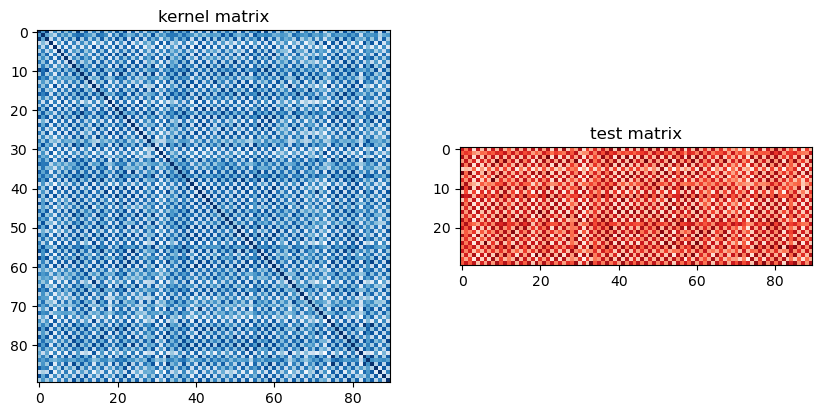

In [25]:
# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

### Step 3. Quantum SVM
We can now use the kernel matrix in the support vector machine class in sklearn and train it to build the statevector classifier SVC

In [26]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel}")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel}")

Quantum SVC classification training accuracy: 1.0
Quantum SVC classification test accuracy: 1.0


### Step 4. Classical SVM for Comparison
This is impressive accuracy, but in general it might not be this good. To compare with classical SVM, let use the same dataset for a classical SVM

In [27]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c:.2f}")
print(f"Classical SVC test accuracy:     {test_score_c:.2f}")

Classical SVC training accuracy: 0.91
Classical SVC test accuracy:     0.67


The notebook is based on materials from various sources including  [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning). However, it has been significantly modified. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)